In [1]:
import os
import re

import numpy as np
import pandas as pd

import igraph as ig
import leidenalg as la

import sqlite3
from sklearn.preprocessing import StandardScaler
import umap

import matplotlib.pyplot as plt
import seaborn as sns

from explorer import UE, get_crops, sample_df
from cellutils.utils import get_data_cols

2025-06-13 14:51:02.709839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 14:51:02.721261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 14:51:02.724831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 14:51:02.733529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-13 14:51:03.453352: W tensorflow/compiler/tf2

In [2]:
### Data ###
db = "/mnt/sextonlabdata/Active_Users_Data/Max/DILI/HDS_Screens_Pooled/65C_AllHDS_042025/Morphology/PerCell/HepG2_Plate1_Morphology.sqlite"
img_dir = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/'
############

In [3]:
con = sqlite3.connect(db)
df = pd.read_sql_query('SELECT * From Per_Image', con)
df.head()

,ImageNumber,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,Image_ExecutionTime_06MeasureTexture,Image_ExecutionTime_07MeasureGranularity,...,Mean_Nuclei_AreaShape_Zernike_8_6,Mean_Nuclei_AreaShape_Zernike_8_8,Mean_Nuclei_AreaShape_Zernike_9_1,Mean_Nuclei_AreaShape_Zernike_9_3,Mean_Nuclei_AreaShape_Zernike_9_5,Mean_Nuclei_AreaShape_Zernike_9_7,Mean_Nuclei_AreaShape_Zernike_9_9,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y
0,1,94,94,0.0,0.0,1.656250,0.0,1.171875,0.703125,15.734375,...,0.009191,0.007800,0.006755,0.006860,0.006730,0.006823,0.005044,1.0,1037.501549,1128.192435
1,2,48,48,0.0,0.0,2.203125,0.0,1.984375,1.437500,29.468750,...,0.007861,0.009008,0.007016,0.006269,0.006634,0.005928,0.005542,1.0,661.217697,920.458529
2,3,59,59,0.0,0.0,2.281250,0.0,2.109375,1.281250,28.593750,...,0.008029,0.009704,0.005578,0.006127,0.006941,0.006096,0.005375,1.0,787.809479,913.328143
3,4,100,100,0.0,0.0,2.625000,0.0,2.406250,1.140625,28.953125,...,0.009024,0.009718,0.006665,0.007591,0.007414,0.007329,0.005468,1.0,1149.068604,926.580530
4,5,151,151,0.0,0.0,2.250000,0.0,2.250000,1.343750,28.093750,...,0.008284,0.009688,0.006288,0.006365,0.006092,0.006072,0.004804,1.0,901.828770,1027.020000


In [4]:
df['WellID'] = df['Image_FileName_DNA'].apply(lambda x: x.split('_')[1])
df['FieldID'] = df['Image_FileName_DNA'].apply(lambda x: x.split('_')[-1][6:9])

In [5]:
df['FieldID'].unique()

array(['001', '002', '003', '004', '005', '006', '007', '008', '009'],
      dtype=object)

In [6]:
meta_cols = df.columns[df.columns.str.contains(pat="Location|Center|Children|Parent|Scaling|ExecutionTime")].tolist()
data_cols = df.drop(columns=meta_cols).select_dtypes(include='float64').columns.tolist()

In [7]:
X = StandardScaler().fit_transform(df[data_cols])

In [8]:
embedder = umap.UMAP(random_state=42)

In [9]:
df[['umap_1', 'umap_2']] = embedder.fit_transform(X)

/home/ben/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='umap_1', ylabel='umap_2'>

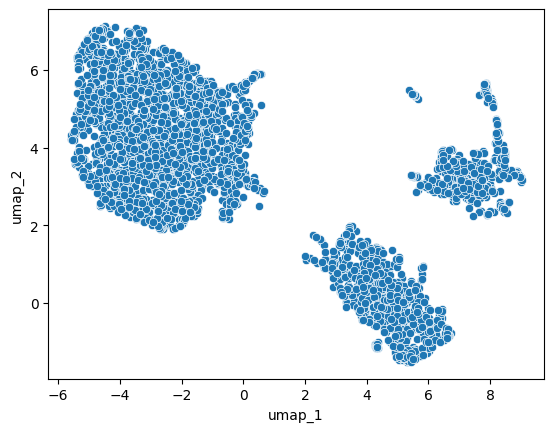

In [10]:
sns.scatterplot(data=df, x='umap_1', y='umap_2')

In [11]:
meta = pd.read_csv('/mnt/sextonlabdata/Active_Users_Data/Max/DILI/HDS_Screens_Pooled/65C_AllHDS_042025/Morphology/PerCell/SceeningPlatesEchoFormatFromHDSSourcePlate2.csv')
meta.head()

,Destination Well,Transfer Volume,Source Well,Compound,Concentration (µM),Source Plate,Destination Plate
0,E21,500.0,E05,Teucrin A,100.0,HDS Source Plate 2,ScreeningPlate1
1,H08,500.0,E05,Teucrin A,100.0,HDS Source Plate 2,ScreeningPlate1
2,J05,500.0,E05,Teucrin A,100.0,HDS Source Plate 2,ScreeningPlate1
3,D01,167.5,E05,Teucrin A,33.5,HDS Source Plate 2,ScreeningPlate1
4,C17,167.5,E05,Teucrin A,33.5,HDS Source Plate 2,ScreeningPlate1


In [12]:
print(meta.shape)
meta = meta.loc[meta['Destination Plate']=='ScreeningPlate1']
print(meta.shape)

(3840, 7)
(768, 7)


In [13]:
meta = meta[['Destination Well', 'Concentration (µM)','Compound','Destination Plate']]

In [14]:
meta.head()

,Destination Well,Concentration (µM),Compound,Destination Plate
0,E21,100.0,Teucrin A,ScreeningPlate1
1,H08,100.0,Teucrin A,ScreeningPlate1
2,J05,100.0,Teucrin A,ScreeningPlate1
3,D01,33.5,Teucrin A,ScreeningPlate1
4,C17,33.5,Teucrin A,ScreeningPlate1


In [15]:
meta['WellID'] = meta['Destination Well']

In [16]:
meta = meta[['WellID', 'Compound','Concentration (µM)']]

In [17]:
meta['Compound'].unique()

array(['Teucrin A', 'Dihydrokavain', 'Dihydroimethysticin', 'Yangonin',
       'Kavain', '2-6-Deoxy Actein', 'Actein', 'Aristolochic Acid ',
       'Intermedine', 'Intermedine N-Oxide ', 'Lycopsamine ',
       'Ginsenoside Rb1 ', 'B- Boswellic Acid ', 'a- Boswellic Acid ',
       '2-3-4-5-Tetrahydroxy-Stilbene-2-Glucoside ', 'Baicalin',
       'Baicalein', 'Sennoside B', 'Sennoside A', 'Berberine ', 'Aloin A',
       'Aloin B', 'Aloe-Emodin ', 'Resveratrol ', 'Knipholone ', 'DMSO',
       'DMSO norm'], dtype=object)

In [18]:
meta = meta.loc[meta['Compound']!='DMSO norm']

In [19]:
print(df.shape)
df = pd.merge(df, meta, on='WellID', how='left')
print(df.shape)

(3456, 678)
(3456, 680)


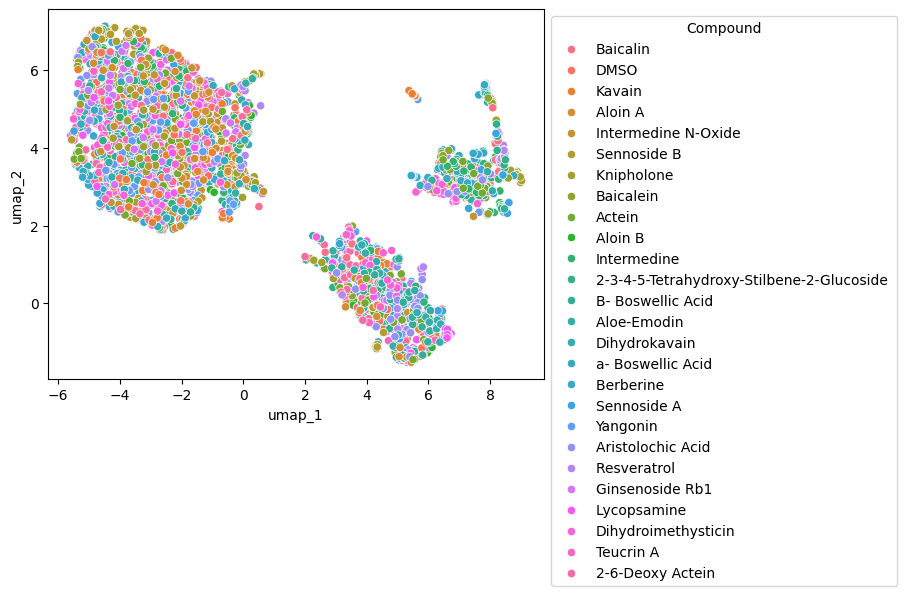

In [20]:
ax = sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='Compound')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [21]:
data = df[['umap_1','umap_2']].values
dist_matrix = np.sqrt((data[:, 0, None] - data[:, 0])**2 + (data[:, 1, None] - data[:, 1])**2)
graph = ig.Graph.Adjacency((dist_matrix < 1).tolist())
partition = la.find_partition(graph, la.ModularityVertexPartition, )
df['cluster'] = partition.membership

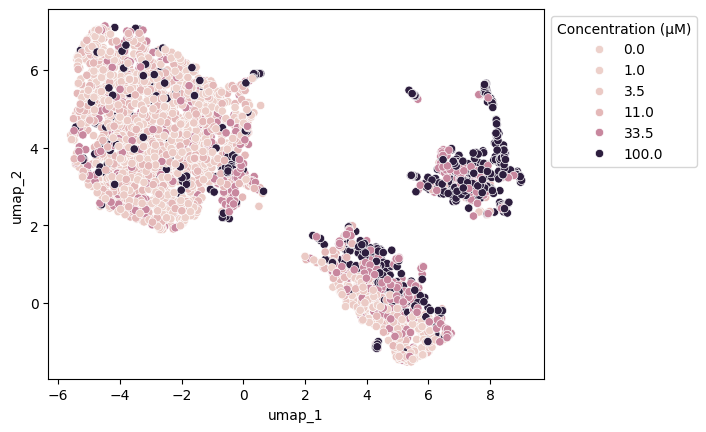

In [22]:
ax = sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='Concentration (µM)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

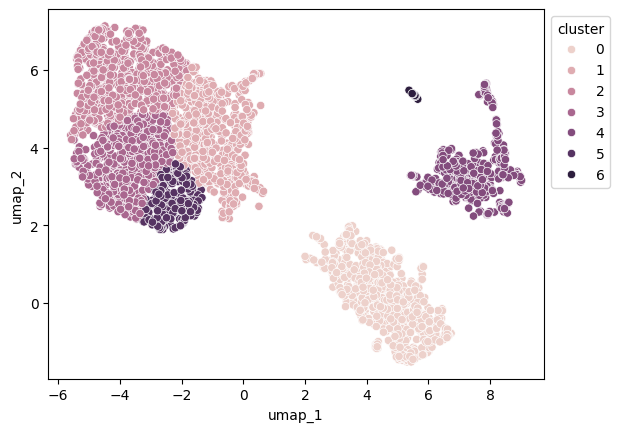

In [23]:
ax = sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='cluster')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [24]:
from sklearn.metrics import silhouette_score

In [25]:
silh_score = silhouette_score(df[['umap_1', 'umap_2']], df['cluster'])

In [26]:
silh_score

0.43036208

In [27]:
from cellutils.image_sampler import sample_df

In [28]:
df.shape

(3456, 681)

In [29]:
obj = pd.read_sql_query("SELECT * FROM Per_Object", con)

In [30]:
obj['Cell_AreaShape_Area'].mean(), obj['Cell_AreaShape_Area'].min(), obj['Cell_AreaShape_Area'].max(), 

(1158.1371929104548, 15.0, 1333525.0)

In [31]:
obj['Cell_AreaShape_Area'].std()

3456.9782776477027

In [32]:
cutoff = 1158.1371929104548 + (3*3456.9782776477027)
cutoff

11529.072025853564

In [33]:
print(obj.shape)
obj = obj.loc[obj['Cell_AreaShape_Area']>= cutoff]
print(obj.shape)

(419096, 289)
(670, 289)


In [34]:
obj =  obj[['ImageNumber', 'ObjectNumber','Cell_AreaShape_Area']]

In [35]:
dx = pd.merge(obj, df, on='ImageNumber', how='left')
dx.shape

(670, 683)

In [36]:
dx.head()

,ImageNumber,ObjectNumber,Cell_AreaShape_Area,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,...,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y,WellID,FieldID,umap_1,umap_2,Compound,Concentration (µM),cluster
0,54,11,13267.0,41,41,0.0,0.0,2.578125,0.0,3.046875,...,1.0,1009.000114,1440.247508,A06,009,-0.783683,4.753607,Kavain,11.0,1
1,55,34,17717.0,175,175,0.0,0.0,2.531250,0.0,4.703125,...,1.0,938.085222,974.930281,A07,001,-5.005775,6.801377,Sennoside B,1.0,2
2,71,10,12525.0,58,58,0.0,0.0,2.421875,0.0,2.625000,...,1.0,1019.973918,1138.396458,A08,008,-0.116277,3.361670,Knipholone,33.5,1
3,100,46,12057.0,79,79,0.0,0.0,2.328125,0.0,2.906250,...,1.0,936.063398,813.883646,A12,001,-0.102833,4.693682,Aloin B,1.0,1
4,136,94,11851.0,130,130,0.0,0.0,2.171875,0.0,3.453125,...,1.0,1122.511342,735.469645,A16,001,-4.449101,6.160638,Aloe-Emodin,3.5,2


In [37]:
dx.cluster.unique()

array([1, 2, 4, 0, 5, 3])

In [38]:
dt = sample_df(dx, cluster_col='cluster', n=10)

In [39]:
dt.shape

(60, 683)

In [40]:
dt.head()

,ImageNumber,ObjectNumber,Cell_AreaShape_Area,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,...,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y,WellID,FieldID,umap_1,umap_2,Compound,Concentration (µM),cluster
0,2069,4,26224.0,87,87,0.0,0.0,2.375000,0.0,1.968750,...,1.0,1260.411097,754.014924,J14,008,4.955992,-1.194258,Ginsenoside Rb1,100.0,0
1,1947,21,11590.0,25,25,0.0,0.0,1.906250,0.0,1.812500,...,1.0,847.198147,494.415656,J01,003,2.286289,1.109274,Knipholone,3.5,0
2,3057,195,16709.0,462,462,0.0,0.0,2.125000,0.0,2.234375,...,1.0,823.711572,1116.792519,O04,006,5.182687,-1.411708,Lycopsamine,3.5,0
3,252,66,14170.0,69,69,0.0,0.0,2.171875,0.0,2.250000,...,1.0,1062.126049,1475.752605,B04,009,4.374703,-0.992736,Sennoside A,100.0,0
4,3362,53,19985.0,93,93,0.0,0.0,2.421875,0.0,1.875000,...,1.0,948.508192,887.230026,P14,005,6.036417,-0.711634,2-6-Deoxy Actein,3.5,0


In [41]:
from cellutils.image_sampler import get_crops

In [42]:
'/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/M'

'/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/M'

In [43]:
dt.head()

,ImageNumber,ObjectNumber,Cell_AreaShape_Area,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,...,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y,WellID,FieldID,umap_1,umap_2,Compound,Concentration (µM),cluster
0,2069,4,26224.0,87,87,0.0,0.0,2.375000,0.0,1.968750,...,1.0,1260.411097,754.014924,J14,008,4.955992,-1.194258,Ginsenoside Rb1,100.0,0
1,1947,21,11590.0,25,25,0.0,0.0,1.906250,0.0,1.812500,...,1.0,847.198147,494.415656,J01,003,2.286289,1.109274,Knipholone,3.5,0
2,3057,195,16709.0,462,462,0.0,0.0,2.125000,0.0,2.234375,...,1.0,823.711572,1116.792519,O04,006,5.182687,-1.411708,Lycopsamine,3.5,0
3,252,66,14170.0,69,69,0.0,0.0,2.171875,0.0,2.250000,...,1.0,1062.126049,1475.752605,B04,009,4.374703,-0.992736,Sennoside A,100.0,0
4,3362,53,19985.0,93,93,0.0,0.0,2.421875,0.0,1.875000,...,1.0,948.508192,887.230026,P14,005,6.036417,-0.711634,2-6-Deoxy Actein,3.5,0


In [44]:
img_dir  = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/PECCU/'
mask_dir = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/Masks/'

In [45]:
get_crops(dt, img_dir, mask_dir, 'sample_dir', 
          diam_col='Cell_AreaShape_Area', diam_val=cutoff, 
          cluster_col='cluster', well_col='WellID', field_col='FieldID', )

20it [00:40,  1.98s/it]/home/ben/.local/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning:

sample_dir/cluster_4_object_20.tif is a low contrast image

21it [00:43,  2.11s/it]/home/ben/.local/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning:

sample_dir/cluster_4_object_21.tif is a low contrast image

22it [00:45,  2.12s/it]/home/ben/.local/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning:

sample_dir/cluster_4_object_22.tif is a low contrast image

23it [00:47,  2.04s/it]/home/ben/.local/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning:

sample_dir/cluster_4_object_23.tif is a low contrast image

24it [00:49,  2.01s/it]/home/ben/.local/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning:

sample_dir/cluster_4_object_24.tif is a low contrast image

30it [01:01,  2.03s/it]


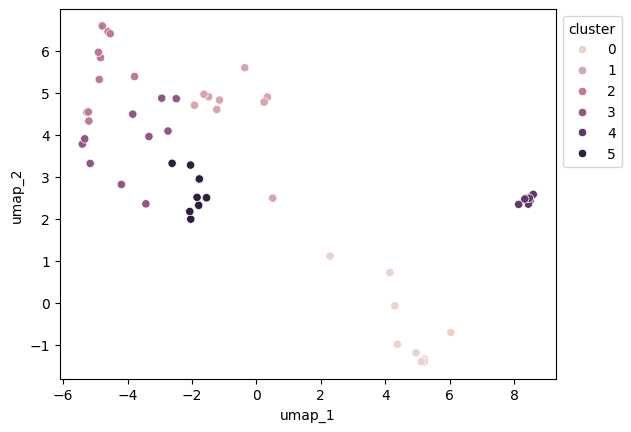

In [46]:
ax = sns.scatterplot(data=dt, x='umap_1', y='umap_2', hue='cluster')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [51]:
df['cluster_id'] = df['cluster'].apply(lambda x: "cluster_"+str(x))
df.head()

,ImageNumber,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,Image_ExecutionTime_06MeasureTexture,Image_ExecutionTime_07MeasureGranularity,...,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y,WellID,FieldID,umap_1,umap_2,Compound,Concentration (µM),cluster,cluster_id
0,1,94,94,0.0,0.0,1.656250,0.0,1.171875,0.703125,15.734375,...,1037.501549,1128.192435,A01,001,6.331204,-0.292277,Baicalin,11.0,0,cluster_0
1,2,48,48,0.0,0.0,2.203125,0.0,1.984375,1.437500,29.468750,...,661.217697,920.458529,A01,002,5.865523,-0.609312,Baicalin,11.0,0,cluster_0
2,3,59,59,0.0,0.0,2.281250,0.0,2.109375,1.281250,28.593750,...,787.809479,913.328143,A01,003,6.146121,-0.874822,Baicalin,11.0,0,cluster_0
3,4,100,100,0.0,0.0,2.625000,0.0,2.406250,1.140625,28.953125,...,1149.068604,926.580530,A01,004,6.055225,-1.034237,Baicalin,11.0,0,cluster_0
4,5,151,151,0.0,0.0,2.250000,0.0,2.250000,1.343750,28.093750,...,901.828770,1027.020000,A01,005,6.074785,-0.621648,Baicalin,11.0,0,cluster_0


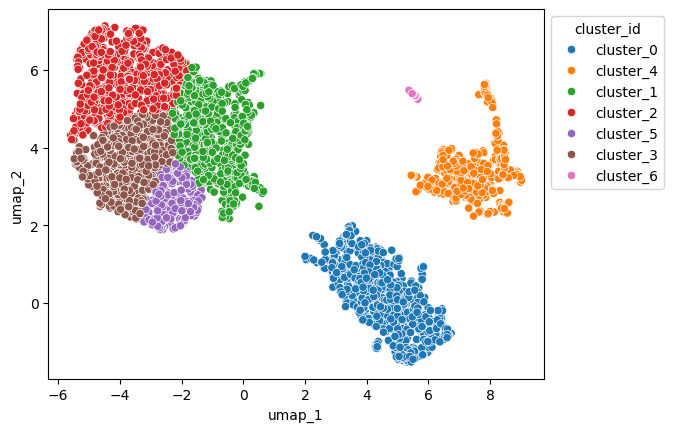

In [52]:
ax = sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='cluster_id')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("umap_cluster.png", format='PNG',bbox_inches='tight')

In [53]:
dt.columns[dt.columns.str.contains(pat="Bounding", flags=re.IGNORECASE)].tolist()

['Mean_Cell_AreaShape_BoundingBoxArea',
 'Mean_Cell_AreaShape_BoundingBoxMaximum_X',
 'Mean_Cell_AreaShape_BoundingBoxMaximum_Y',
 'Mean_Cell_AreaShape_BoundingBoxMinimum_X',
 'Mean_Cell_AreaShape_BoundingBoxMinimum_Y',
 'Mean_Nuclei_AreaShape_BoundingBoxArea',
 'Mean_Nuclei_AreaShape_BoundingBoxMaximum_X',
 'Mean_Nuclei_AreaShape_BoundingBoxMaximum_Y',
 'Mean_Nuclei_AreaShape_BoundingBoxMinimum_X',
 'Mean_Nuclei_AreaShape_BoundingBoxMinimum_Y']

In [54]:
dt.columns[dt.columns.str.contains(pat="location|center", flags=re.IGNORECASE)].tolist()

['Image_Metadata_FileLocation',
 'Mean_Cell_AreaShape_Center_X',
 'Mean_Cell_AreaShape_Center_Y',
 'Mean_Cell_Location_Center_X',
 'Mean_Cell_Location_Center_Y',
 'Mean_Cell_Location_Center_Z',
 'Mean_Nuclei_AreaShape_Center_X',
 'Mean_Nuclei_AreaShape_Center_Y',
 'Mean_Nuclei_Location_Center_X',
 'Mean_Nuclei_Location_Center_Y']

In [56]:
dt.shape, df.shape

((60, 683), (3456, 682))

In [62]:
dx['cluster_id'] = dx['cluster'].apply(lambda x: "cluster_"+str(x))


In [64]:
df.to_csv("test_data.csv", index=False)

In [58]:
data_cols

['Image_Granularity_10_DNA',
 'Image_Granularity_10_LipidTox',
 'Image_Granularity_10_Mitotracker',
 'Image_Granularity_10_WholeCell',
 'Image_Granularity_11_DNA',
 'Image_Granularity_11_LipidTox',
 'Image_Granularity_11_Mitotracker',
 'Image_Granularity_11_WholeCell',
 'Image_Granularity_12_DNA',
 'Image_Granularity_12_LipidTox',
 'Image_Granularity_12_Mitotracker',
 'Image_Granularity_12_WholeCell',
 'Image_Granularity_13_DNA',
 'Image_Granularity_13_LipidTox',
 'Image_Granularity_13_Mitotracker',
 'Image_Granularity_13_WholeCell',
 'Image_Granularity_14_DNA',
 'Image_Granularity_14_LipidTox',
 'Image_Granularity_14_Mitotracker',
 'Image_Granularity_14_WholeCell',
 'Image_Granularity_15_DNA',
 'Image_Granularity_15_LipidTox',
 'Image_Granularity_15_Mitotracker',
 'Image_Granularity_15_WholeCell',
 'Image_Granularity_16_DNA',
 'Image_Granularity_16_LipidTox',
 'Image_Granularity_16_Mitotracker',
 'Image_Granularity_16_WholeCell',
 'Image_Granularity_1_DNA',
 'Image_Granularity_1_Lipid

In [59]:
import pickle

In [61]:
with open('test_data_cols', 'wb') as f:
    pickle.dump(data_cols, f)